### Multimodal Generation

- habilitade de conectar diferente modalidades de arquiteturas de IA, neste caso, texto e imagem

- CLIP (Constrative Language-Image Pre-Training) arquiteture  By open.ai from paper "Learning Transferable Visual Models from Natural Language Supervision
- Arquitetura VQGAN:


![Alt text](images/doc/text_image_encoder.png "Multimodal Model")

#### Importing libraries

In [1]:
!git clone https://github.com/openai/CLIP.git

fatal: destination path 'CLIP' already exists and is not an empty directory.


In [2]:
!git clone https://github.com/CompVis/taming-transformers

fatal: destination path 'taming-transformers' already exists and is not an empty directory.


In [3]:
## Install some extra libraries

!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip uninstall torchtext --yes
!pip install einops


[notice] A new release of pip is available: 23.3.2 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached omegaconf-2.0.0-py3-none-any.whl.metadata (3.5 kB)
  Using cached pytorch_lightning-1.0.8-py3-none-any.whl.metadata (26 kB)
  Using cached numpy-1.24.4-cp38-cp38-win_amd64.whl.metadata (5.6 kB)
  Using cached torch-2.3.1-cp38-cp38-win_amd64.whl.metadata (26 kB)
  Using cached tensorboard-2.14.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached grpcio-1.64.1-cp38-cp38-win_amd64.whl.metadata (3.4 kB)
  Using cached google_auth-2.30.0-py2.py3-none-any.whl.metadata (4.7 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached Markdown-3.6-py3-none-any.whl.metadata (7.0 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.4 kB)
  Using cached cachetools-5.3.3-py3-none-any.whl.metadata (5.3 kB)
  Using cached pyasn1_modules-0.4.0-py3-none-any.whl.metadata (3.4 kB)
  Using cac

DEPRECATION: dtale 1.31.0 has a non-standard dependency specifier scikit-learn>='0.21.0. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of dtale or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.

[notice] A new release of pip is available: 23.3.2 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


DEPRECATION: dtale 1.31.0 has a non-standard dependency specifier scikit-learn>='0.21.0. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of dtale or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import torch, os, imageio, pdb, math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt


import yaml

In [4]:
from omegaconf import OmegaConf

In [5]:
from CLIP import clip

In [42]:
# Helper functions

def show_from_tensor(tensor):
    img =  tensor.clone()
    img = img.mul(255).byte()
    img = img.cpu().numpy().transpose((1,2,0))

    plt.figure(figsize=(10,7))
    plt.axis('off')
    plt.imshow(img)
    plt.show()


def norm_data(data):
    return (data.clip(-1,1)+1)/2  # range between 0 and 1 in the result

#### Parameters

learning_rate = 0.5
batch_size = 1
wd = 0.1
noise_factor = 0.1

total_iter = 100
im_shape = [225, 400, 3] # height, width, channel
size1, size2, channels = im_shape

In [7]:
# CLIP MODEL
# arquitetura que permite conectar imagens e texto
# Vamos usar o CLIP MODEL para codificar as entradas do PROMPT e a imagem que estamos gerando

clipmodel, _ = clip.load('ViT-B/32', jit=False)
clipmodel.eval()
print(clip.available_models())

print('CLip model visual input resolution: ', clipmodel.visual.input_resolution)
device = torch.device('cpu')


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
CLip model visual input resolution:  224


In [9]:
print(os.getcwd())

C:\Users\pedro\Projetos\genia


In [10]:
%cd taming-transformers/

!mkdir -p models\vqgan_imagenet_f16_16384\checkpoints
!mkdir -p models\vqgan_imagenet_f16_16384\configs

J  existe uma subpasta ou um arquivo -p.
Erro ao processar: -p.


In [11]:
'''
if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0:
    !curl -L 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
    !curl -L 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml'
'''

"\nif len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0:\n    !curl -L 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'\n    !curl -L 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml'\n"

In [18]:
import requests
import os

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) != 991:
    # URL do arquivo
    url = 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1'
    
    # Caminho local onde o arquivo será salvo
    local_filename = 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
    
    # Cria os diretórios se não existirem
    os.makedirs(os.path.dirname(local_filename), exist_ok=True)
    
    # Faz o download do arquivo
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    
    print(f"Arquivo baixado e salvo em {local_filename}")


Arquivo baixado e salvo em models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt


In [19]:
if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) != 110:
    # URL do arquivo
    url = 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1'
    
    # Caminho local onde o arquivo será salvo
    local_filename = 'models/vqgan_imagenet_f16_16384/configs/model.yaml'
    
    # Cria os diretórios se não existirem
    os.makedirs(os.path.dirname(local_filename), exist_ok=True)
    
    # Faz o download do arquivo
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    
    print(f"Arquivo baixado e salvo em {local_filename}")


Arquivo baixado e salvo em models/vqgan_imagenet_f16_16384/configs/model.yaml


In [22]:
import sys
sys.path.append(os.path.join(os.getcwd(), 'taming-transformers'))

In [24]:
from taming.models.vqgan import VQModel

In [26]:
def load_config(config_path, display=False):
    config_data = OmegaConf.load(config_path)

    if display:
        print(yaml.dump(OmegaConf.to_container(config_data)))

    return config_data
def load_vqgan(config, chk_path=None):
    model = VQModel(**config.model.params)

    if chk_path is not None:
        state_dict = torch.load(chk_path, map_location='cpu')['state_dict']
        missing, unexpected = model.load_state_dict(state_dict, strict=False)

    return model.eval()

def generator(x):
    x = taming_model.post_quant_conv(x)
    x = taming_model.decoder(x)
    return x

taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
taming_model = load_vqgan(taming_config, chk_path="./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)


model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


C:\Users\pedro\Projetos\genia\ambiente_virtual\genia_venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\pedro\Projetos\genia\ambiente_virtual\genia_venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\pedro/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|███████████████████████████████████████████████████████████████████████████████| 528M/528M [01:02<00:00, 8.80MB/s]


8.19kB [00:00, 35.2kB/s]                                                                                               


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips\vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [63]:
# Declare the values that we are going to optimize

class Parameters(torch.nn.Module):
    def __init__(self):
        super(Parameters, self).__init__()
        # self.data = 0.5 * torch.randn(batch_size, 256, size1//16, size2//16).cuda() # 1x256x14x15 (255/16, 400/16)
        self.data = 0.5 * torch.randn(batch_size, 256, size1//16, size2//16).cpu() # 1x256x14x15 (255/16, 400/16)
        self.data = torch.nn.Parameter(torch.sin(self.data))

    def forward(self):
        return self.data

def init_params():
    # params = Parameters().cuda()
    params = Parameters().cpu()
    optimizer = torch.optim.AdamW([{'params':[params.data], 'lr': learning_rate}], weight_decay = wd)
    return params, optimizer

In [64]:
### Encoding prompts and few more things

normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

def encodeText(text):
    # t = clip.tokenize(text).cuda()
    t = clip.tokenize(text).cpu()
    t = clipmodel.encode_text(t).detach().clone()
    return t

def createEncodings(include, exclude, extras):
    include_enc = []

    for text in include:
        include_enc.append(encodeText(text))

    exclude_enc = encodeText(exclude) if exclude != '' else 0
    extras_enc = encodeText(extras) if extras != '' else 0

    return include_enc, exclude_enc, extras_enc

torch.Size([1, 256, 14, 25])
img dimensions:  torch.Size([1, 3, 224, 400])


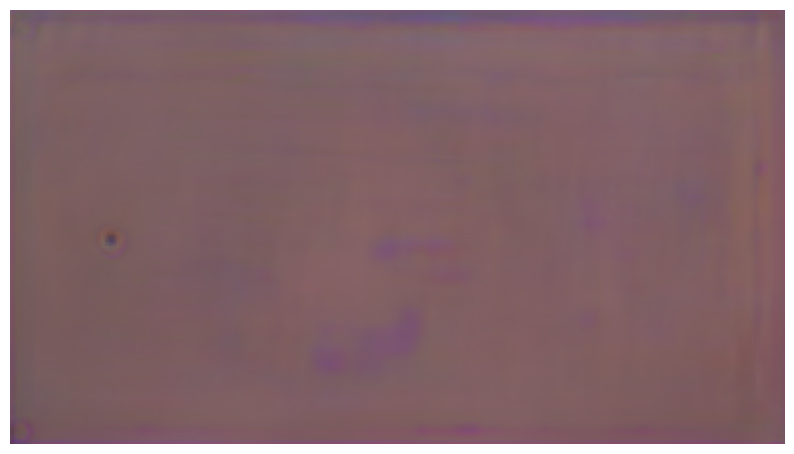

In [65]:
# augTransform = torch.nn.Sequential(
#     torchvision.transforms.RandomHorizontalFlip(),
#     torchvision.transforms.RandomAffine(30, (0.2, 0.2), fill=0)
# ).cuda()

augTransform = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (0.2, 0.2), fill=0)
).cpu()

Params, optimizer = init_params()

with torch.no_grad():
    print(Params().shape)
    img = norm_data(generator(Params()).cpu())  # 1 x 3 x 224 x 400 [255 x 400]
    print("img dimensions: ", img.shape)
    show_from_tensor(img[0]) 

In [78]:
# create crops

def create_crops(img, num_crops=30):
    p = size1//2
    img = torch.nn.functional.pad(img, (p, p, p, p), mode='constant', value=0) # 1 x 3 x 448 x 624 (adding 112*2 on all sides to 223x400)
    img = augTransform(img) 

    crop_set = []
    for ch in range(num_crops):
        gap1 = int(torch.normal(1.0, 0.5, ()).clip(0.2, 1.5) * size1)
        gap2 = int(torch.normal(1.0, 0.5, ()).clip(0.2, 1.5) * size1)

        offsetx = torch.randint(0, int(size1*2 - gap1), ())
        offsety = torch.randint(0, int(size1*2 - gap1), ())

        crop = img[:,:,offsetx:offsetx+gap2, offsety:offsety+gap2]

        crop = torch.nn.functional.interpolate(crop, (224,224), mode='bilinear', align_corners=True)
        crop_set.append(crop)

    img_crops = torch.cat(crop_set, 0) # 30 x 3 x 224 x 224

    img_crops = img_crops + noise_factor * torch.randn_like(img_crops, requires_grad=False)

    return img_crops

In [79]:
def showme(Params, show_crop):
    with torch.no_grad():
        generated = generator(Params())

        if (show_crop):
            print("Augmented cropped example")
            aug_gen = generated.float()  # 1 x 3 x 224 x 400
            aug_gen = create_crops(aug_gen, num_crops=1)
            aug_gen_norm = norm_data(aug_gen[0])
            show_from_tensor(aug_gen_norm)

        print("Generation")
        latest_gen = norm_data(generated.cpu())  # 1 x 3 x 224 x 400
        show_from_tensor(latest_gen[0])

    return latest_gen

In [80]:
# Optimization process

def optimize_result(Params, prompt):

    alpha = 1 # the importance of the include encodings
    beta = 0.5 # the importance of the exclude encondings

    ## image encoding
    out = generator(Params())
    out = norm_data(out)
    out = create_crops(out)
    out = normalize(out) # 30 x 3 x 224 x 224
    image_enc = clipmodel.encode_image(out)

    ## text encoding w1 and w2
    final_enc = w1 * prompt + w1*extras_enc #prompt and extras_enc : 1 x 512
    final_text_include_enc = final_enc / final_enc.norm(dim=-1, keepdim=True) # 1 x 512
    final_text_exclude_enc = exclude_enc

    ## calculate the loss
    main_loss = torch.cosine_similarity(final_text_include_enc, image_enc, -1) # 30
    penalize_loss = torch.cosine_similarity(final_text_exclude_enc, image_enc, -1) # 30

    final_loss = -alpha*main_loss + beta * penalize_loss

    return final_loss


def optimize(Params, optimizer, prompt):
    loss = optimize_result(Params, prompt).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss


In [86]:
### training loop

def training_loop(Params, optimizer, show_crop=False):
    res_img = []
    res_z = []

    for prompt in include_enc:
        iteration = 0
        Params, optimizer = init_params() # 1 x 256 x 14 x 25 (255/16, 400/16)

        for it in range(total_iter):
            loss = optimize(Params, optimizer, prompt)

            if iteration > 0 and iteration % (total_iter-1) == 0:
                new_img = showme(Params, show_crop)
                res_img.append(new_img)
                res_z.append(Params()) # 1 x 256 x 14 x 25
                print("Loss: ", loss.item(), "\iterarion: ", iteration)

            iteration += 1
        #torch.cuda.empty_cache()
    return res_img, res_z
    

Augmented cropped example


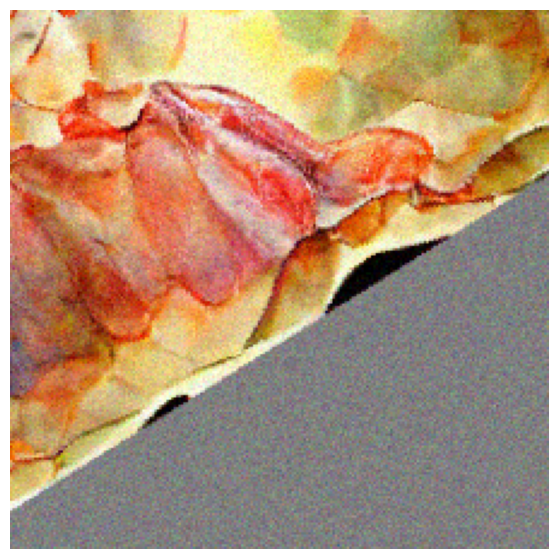

Generation


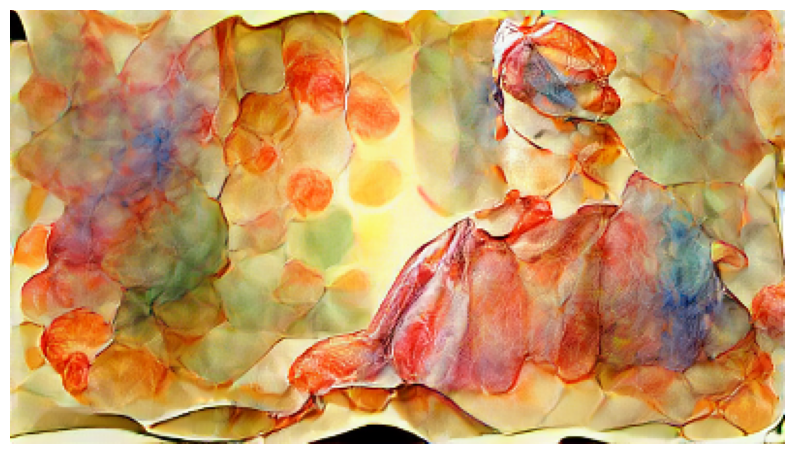

Loss:  -0.1666128784418106 \iterarion:  99
Augmented cropped example


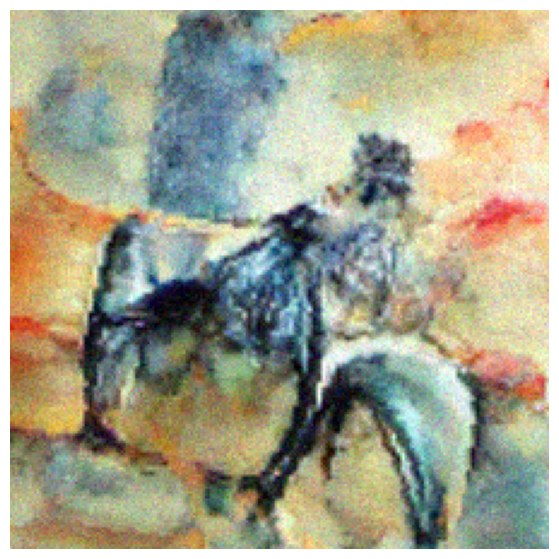

Generation


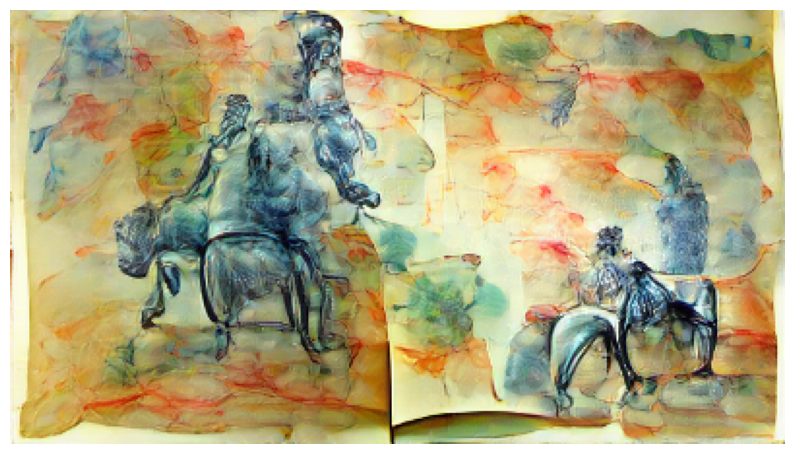

Loss:  -0.21356964111328125 \iterarion:  99


In [87]:
torch.cuda.empty_cache()

include = ['sketch of a lady', 'sketch of a man on a horse']
exclude = 'watermark, cropped, confusing, incoherent, cut, blurry'
extras = 'watercolor paper texture'

w1 = 1
w2 = 1

include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z = training_loop(Params, optimizer, show_crop=True)

In [88]:
print(len(res_img), len(res_z))

2 2


In [89]:
print(res_img[0].shape, res_z[0].shape)

torch.Size([1, 3, 224, 400]) torch.Size([1, 256, 14, 25])


In [90]:
print(res_z[0].max(), res_z[0].min())

tensor(5.9626, grad_fn=<MaxBackward1>) tensor(-6.0744, grad_fn=<MinBackward1>)


Augmented cropped example


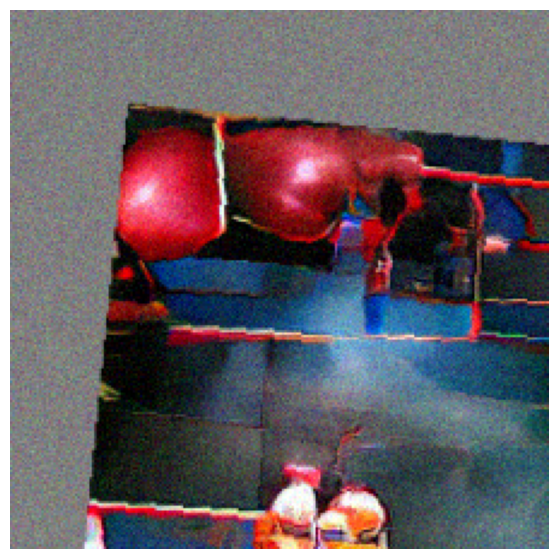

Generation


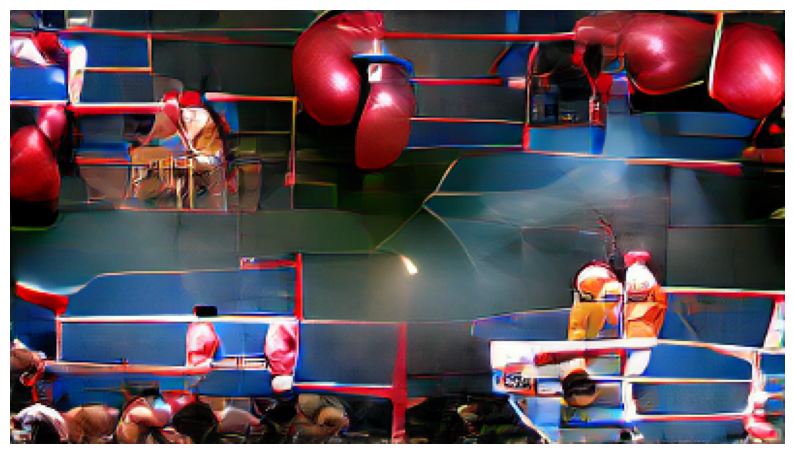

Loss:  -0.21575713157653809 \iterarion:  99
Augmented cropped example


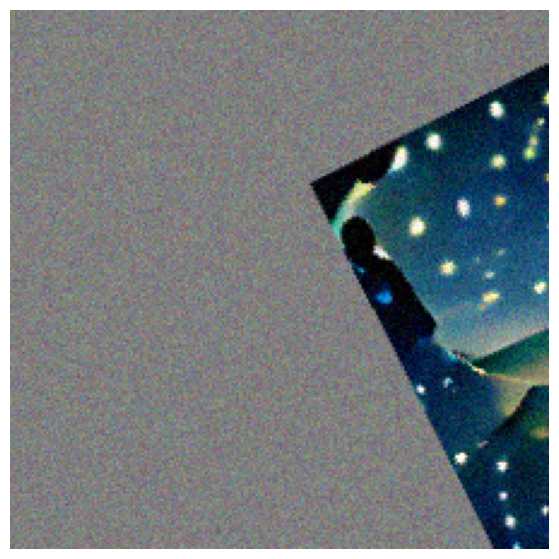

Generation


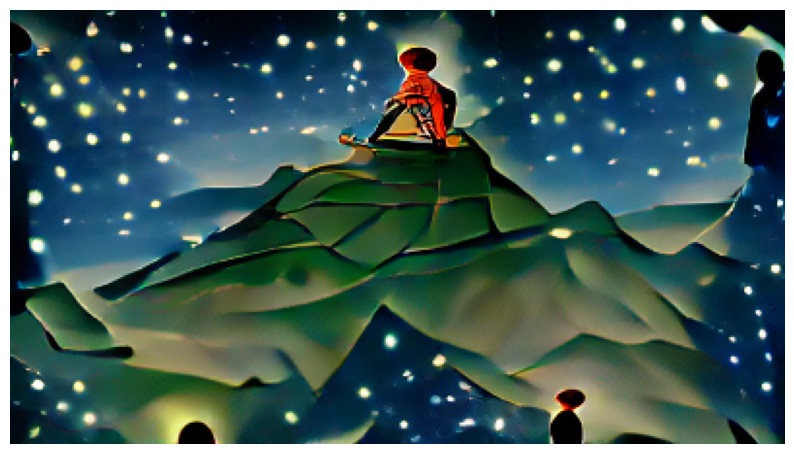

Loss:  -0.21553677320480347 \iterarion:  99
Augmented cropped example


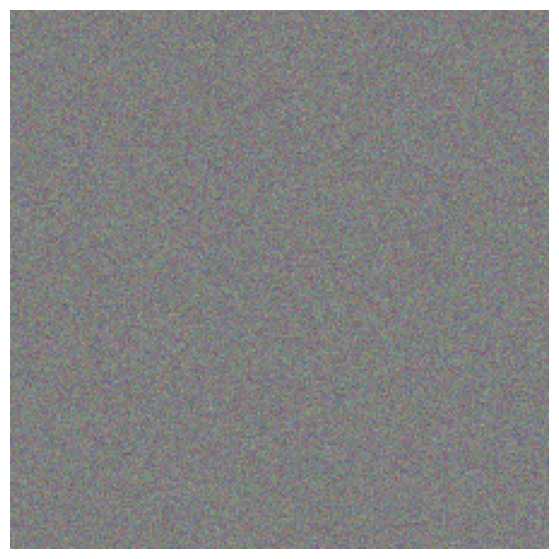

Generation


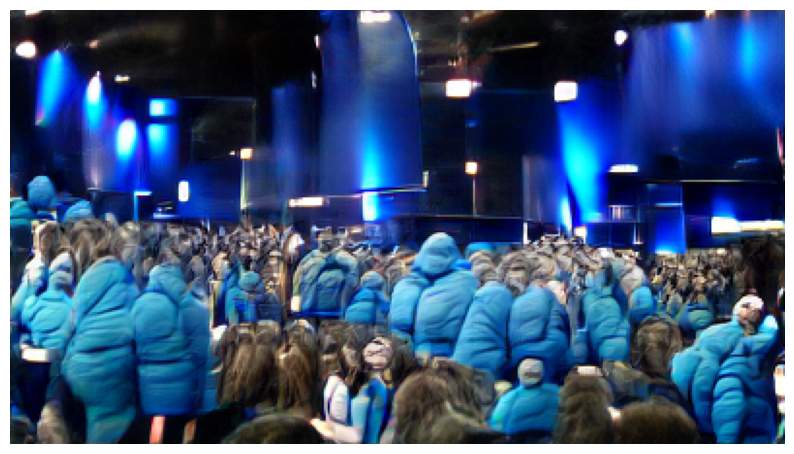

Loss:  -0.2216065227985382 \iterarion:  99


In [91]:
torch.cuda.empty_cache()

include = ['two boxers fighting in a boxing ring', 'a boy at the top of a montain, looking at the stars',
          'one hundred people with blu jackets']
exclude = 'watermark, cropped, confusing, incoherent, cut, blurry'
extras = ''

w1 = 1
w2 = 1

include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z = training_loop(Params, optimizer, show_crop=True)

In [92]:
def interpolate(res_z_list, duration_list):
    gen_img_list = []
    fps = 25

    for idx, (z, duration) in enumerate(zip(res_z_list, duration_list)):
        num_steps = int(duration * fps)
        z1 = z
        z2 = res_z_list[(idx+1)%len(res_z_list)] # 1 x 256 x 14 x 25 (225/16, 400/16)

        for step in range(num_steps):
            alpha = math.size(1.5 * step/num_steps)**6 # value of interpolation that indicates the change between images
            z_new = alpha * z2 + (1-alpha) * z1

            new_gen = norm_data(generator(z_new).cpu())[0] ## 3 x 224 x 400
            new_img = T.ToPILImage(mode='RGB')(new_gen)
            gen_img_list.append(new_img)
    return gen_img_list


durations = [3, 3, 3, 3, 3, 3]
interp_result_img_list = interpolate(res_z, durations)

AttributeError: module 'math' has no attribute 'size'

In [ ]:
### create video

out_video_path = f'../res1/mp4'
writer = imageio.get_writer(out-video_path, fps=25)
for pil_img in interp_result_img_list:
    img = np.array(pill_img, dtype=np.uint8)
    writer.append_data(img)

writer.close()